# Model Evaluation Notebook

This notebook evaluates Logistic Regression, LSTM, and BERT models using Accuracy, Precision, Recall, F1-score, Confusion Matrix, and ROC Curve.

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)


## Load Test Dataset

In [2]:
test_df = pd.read_csv("imdb_reviews.csv")

X_test = test_df["text"]
y_test = test_df["label"]

y_test.head()


0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

## Logistic Regression Evaluation

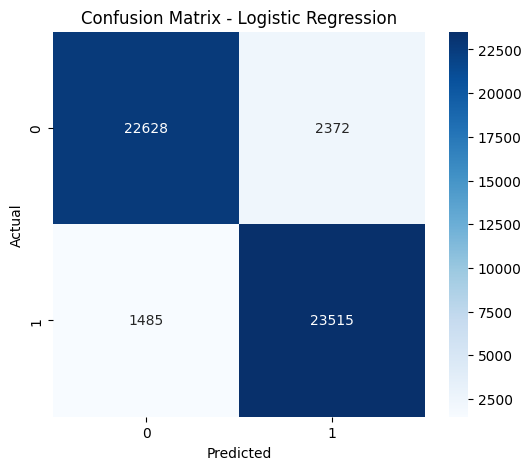

Accuracy: 0.9229
Precision: 0.9084
Recall: 0.9406
F1-score: 0.9242


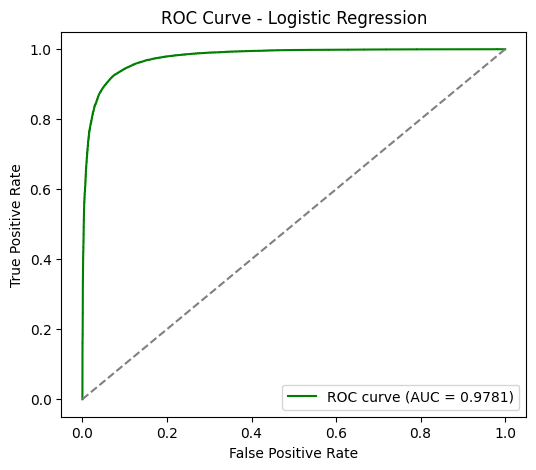

In [41]:
# Logistic Regression Evaluation

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score
import joblib

# ---------------- Load model & vectorizer ----------------
vectorizer = joblib.load("src/models/tfidf_vectorizer.joblib")
log_model = joblib.load("src/models/logreg_tfidf.joblib")

# ---------------- Transform test set ----------------
X_test_tfidf = vectorizer.transform(X_test)

# ---------------- Predictions ----------------
y_pred_log = log_model.predict(X_test_tfidf)
y_prob_log = log_model.predict_proba(X_test_tfidf)[:,1]  # probability for positive class

# ---------------- Confusion Matrix ----------------
cm = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# ---------------- Classification Metrics ----------------
acc = accuracy_score(y_test, y_pred_log)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_log, average="binary", pos_label=1)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# ---------------- ROC Curve ----------------
fpr, tpr, thresholds = roc_curve(y_test, y_prob_log)
auc_score = roc_auc_score(y_test, y_prob_log)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='green', label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


## LSTM Evaluation

C:\Users\komal\AppData\Local\Temp\ipykernel_15696\3545547027.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("src/models/lstm/lstm_model.pth", map_location=d

LSTM Evaluation
Accuracy : 0.8825
Precision: 0.9248
Recall   : 0.8327
F1 Score : 0.8763


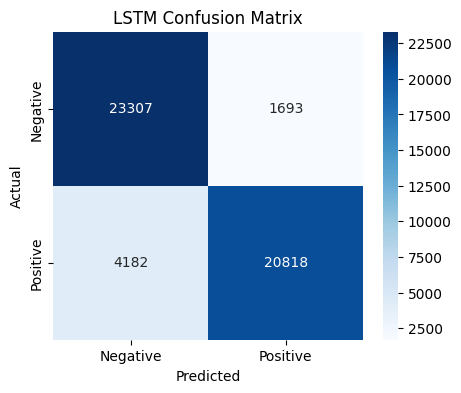

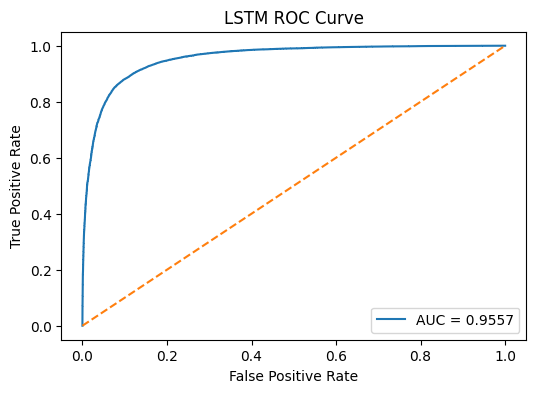

In [24]:
import torch
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc
)

from src.LSTM import LSTMSentiment, SimpleTokenizer

device = torch.device("cpu")
tokenizer = SimpleTokenizer()
tokenizer.word2idx = joblib.load("src/models/lstm/tokenizer_word2idx.joblib")
UNK_IDX = tokenizer.word2idx.get("<UNK>", 1)

# Load model
VOCAB_SIZE = len(tokenizer.word2idx)

model = LSTMSentiment(
    VOCAB_SIZE,  # vocab_size
    128,         # embed_dim
    128,         # hidden_dim
    2,           # output_dim (classes)
    2            # n_layers
)

model.load_state_dict(
    torch.load("src/models/lstm/lstm_model.pth", map_location=device)
)
model.to(device)
model.eval()

MAX_LEN = 200   
def encode(text, max_len=MAX_LEN):
    tokens = [
        tokenizer.word2idx.get(w, UNK_IDX)
        for w in text.lower().split()
    ][:max_len]

    return tokens + [0] * (max_len - len(tokens))

batch_size = 32
y_prob_lstm = []

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch_texts = X_test[i:i + batch_size]

        batch_encoded = torch.tensor(
            [encode(t) for t in batch_texts],
            dtype=torch.long
        ).to(device)

        logits = model(batch_encoded)
        probs = torch.softmax(logits, dim=1)[:, 1]

        y_prob_lstm.extend(probs.cpu().numpy())

y_prob_lstm = np.array(y_prob_lstm)
THRESHOLD = 0.4
y_pred_lstm = (y_prob_lstm > THRESHOLD).astype(int)


acc = accuracy_score(y_test, y_pred_lstm)
prec = precision_score(y_test, y_pred_lstm)
rec = recall_score(y_test, y_pred_lstm)
f1 = f1_score(y_test, y_pred_lstm)

print("LSTM Evaluation")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")

cm = confusion_matrix(y_test, y_pred_lstm)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LSTM Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob_lstm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LSTM ROC Curve")
plt.legend()
plt.show()


## BERT Evaluation

Predicting: 100%|████████████████████████████████████████████████████████████████████| 157/157 [06:26<00:00,  2.46s/it]


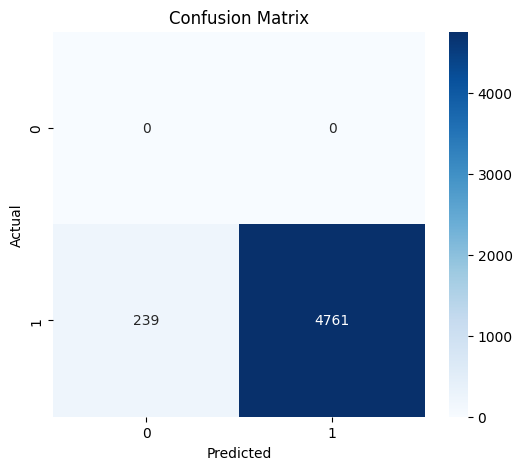

Accuracy: 0.9522
Precision: 1.0000
Recall: 0.9522
F1-score: 0.9755


C:\Users\komal\anaconda3\envs\CRNN\lib\site-packages\sklearn\metrics\_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
C:\Users\komal\anaconda3\envs\CRNN\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


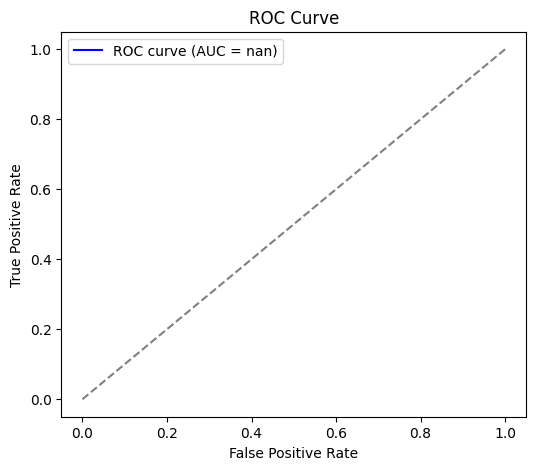

In [40]:

import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# ---------------- Load dataset ----------------
test_df = pd.read_csv("imdb_reviews.csv")  # CHANGE PATH IF NEEDED
X_test = test_df["text"]
y_test = test_df["label"]

# ---------------- Load model & tokenizer ----------------
model_path = "src/models/distilbert"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

subset_size = 5000
X_test_subset = X_test[:subset_size]
y_test_subset = y_test[:subset_size]

# ---------------- Tokenize all texts ----------------
encodings = tokenizer(list(X_test_subset), truncation=True, padding=True, max_length=128, return_tensors="pt")
input_ids = encodings["input_ids"].to(device)
attention_mask = encodings["attention_mask"].to(device)

# ---------------- Batch inference ----------------
batch_size = 32
dataset = TensorDataset(input_ids, attention_mask)
loader = DataLoader(dataset, batch_size=batch_size)

y_pred, y_prob = [], []

with torch.no_grad():
    for batch in tqdm(loader, desc="Predicting"):
        input_ids_batch, attention_mask_batch = batch
        logits = model(input_ids=input_ids_batch, attention_mask=attention_mask_batch).logits
        probs = torch.softmax(logits, dim=1)
        
        y_prob.extend(probs[:,1].cpu().numpy())         # probability for positive class
        y_pred.extend(torch.argmax(probs, dim=1).cpu().numpy())

# ---------------- Confusion Matrix ----------------
cm = confusion_matrix(y_test_subset, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ---------------- Classification Metrics ----------------
acc = accuracy_score(y_test_subset, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test_subset, y_pred, average="binary", pos_label=1)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# ---------------- ROC Curve ----------------
fpr, tpr, thresholds = roc_curve(y_test_subset, y_prob)
auc_score = roc_auc_score(y_test_subset, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
